In [1]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import janitor
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import contextily
from pysal.lib import weights
from pysal.model import spreg

In [2]:
PATH_TO_PROCESSED_FILES = Path("../data/processed/")
ROME_GEOJSON = (
    PATH_TO_PROCESSED_FILES / "Rome_urban_zones_with_features_and_emissions_clean__epsg4326.geojson"
)
COMPUTE_G_AUTOCORRELATION = False

## Loading the spatial tessellation

In [3]:
gdf_rome = gpd.read_file(ROME_GEOJSON)
print(gdf_rome.shape)

(155, 21)


Based on [Spatial Regression — Geographic Data Science with Python](https://geographicdata.science/book/notebooks/11_regression.html)

In [4]:
gdf_rome.drop(columns="geometry").head()

,area_code,area_name,SHAPE_Leng,SHAPE_Area,n_traffic_lights,density_traffic_lights,n_shops,density_shops,perc_roads_bc,car_accidents,perc_people_far_from_public_transport,pop_density,avg_CO_2_per_road,CO_2_alpha,avg_NO_x_per_road,NO_x_alpha,avg_PM_per_road,PM_alpha,avg_VOC_per_road,VOC_alpha
0,10L,Morena,22732.760455,8.947226e+06,10,1.117665,960,107.295822,2.447164,182,2.8,36.9,45.691790,1.379673,0.028145,1.379998,0.000711,1.372780,0.135578,1.360149
1,10A,Don Bosco,8400.069997,2.256348e+06,17,7.534299,1854,821.681815,2.533784,367,93.6,225.9,19.736626,1.506453,0.024918,1.753734,0.000606,1.675556,0.078710,1.261183
2,10B,Appio-Claudio,9265.317994,3.454590e+06,16,4.631520,1236,357.784910,1.465201,239,99.8,86.1,17.311154,1.406042,0.013976,1.272973,0.000557,1.558339,0.067396,1.041726
3,10C,Quarto Miglio,11017.098179,5.030157e+06,9,1.789208,738,146.715093,6.109980,144,35.1,21.7,297.379845,1.387901,0.107992,1.418191,0.001484,1.267525,0.525855,1.523452
4,10D,Pignatelli,5161.962256,9.972986e+05,2,2.005417,178,178.482157,0.000000,50,0.0,66.3,33.474434,1.065894,0.023046,1.000000,0.000804,1.221868,0.103474,1.000000


In [5]:
feature = "car_accidents"

In [6]:
def _choropleth(gdf: gpd.GeoDataFrame, 
    column: str,
    **kwargs,
):
    kwargs = {**dict(    
        cmap='viridis', 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75,
        figsize=(9,9),
        legend=True,
        ), **kwargs}

    f, ax = plt.subplots(1, figsize=kwargs["figsize"])
    return gdf.plot(column=column, 
            ax=ax,
            **kwargs,
        )

def choropleth(
    gdf: gpd.GeoDataFrame, 
    column: str,
    cmap='viridis', 
    edgecolor='white', 
    legend_kwds={"loc": 1},
    linewidth=0., 
    alpha=0.75, 
    basemap=True,
    figsize=(9,9),
    title=None,
    **kwargs,
):
    kwargs["scheme"] = kwargs.get("scheme", "quantiles")
    kwargs["k"] = kwargs.get("k", 5)
    title = title or f"{column}"

    ax=_choropleth(gdf,
            column=column, 
            cmap=cmap, 
            edgecolor=edgecolor, 
            linewidth=linewidth, 
            alpha=alpha, 
            figsize=figsize,
            **kwargs,
        )
    if basemap:
        contextily.add_basemap(ax, 
                            crs=gdf.crs, 
                            source=contextily.providers.OpenStreetMap.Mapnik
                            )
    ax.set_title(title)
    ax.set_axis_off()

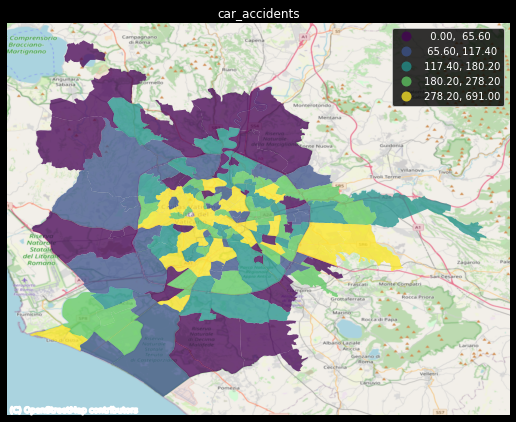

In [7]:
choropleth(gdf_rome, feature)

In [8]:
gdf_rome_connected = gdf_rome.drop(index=[97])

In [9]:
w = weights.Rook.from_dataframe(gdf_rome_connected)
w.transform = 'R'
assert w.n_components == 1

## Linear regression

Based on [Spatial Regression — Geographic Data Science with Python](https://geographicdata.science/book/notebooks/11_regression.html)

In [10]:
dependent_variable = feature
independent_variables = ["density_traffic_lights", "density_shops"]

In [11]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    gdf_rome_connected[dependent_variable].values, 
    # Independent variables
    gdf_rome_connected[independent_variables].values,
    # Dependent variable name
    name_y=dependent_variable, 
    # Independent variable name
    name_x=independent_variables,
    w=w,
    spat_diag=True,
    moran=True,
)

In [12]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :car_accidents                Number of Observations:         154
Mean dependent var  :    182.3052                Number of Variables   :           3
S.D. dependent var  :    140.5497                Degrees of Freedom    :         151
R-squared           :      0.2636
Adjusted R-squared  :      0.2539
Sum squared residual: 2225592.282                F-statistic           :     27.0304
Sigma-square        :   14739.022                Prob(F-statistic)     :   9.239e-11
S.E. of regression  :     121.404                Log likelihood        :    -956.067
Sigma-square ML     :   14451.898                Akaike info criterion :    1918.135
S.E of regression ML:    120.2160                Schwarz criterion     :    1927.245

----------------------------------------------------------------------------

In [13]:
m1.moran_res

(0.08621711572459718, 1.9186586086903625, 0.05502755305741811)

### Residuals

In [14]:
def choropleth_residuals(gdf, column, **kwargs):
    max_abs_value = gdf[column].abs().max()
    norm = TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)
    kwargs = {**dict(
                norm=norm, 
                cmap="coolwarm", 
                scheme=None, 
                k=None,
                edgecolor="black", 
                linewidth=0.5
                ),
              **kwargs}

    ax = choropleth(gdf, 
        column=column, 
        **kwargs,
    )
    return ax

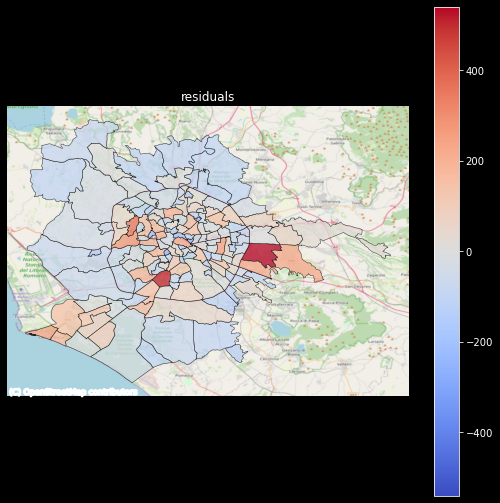

In [15]:
gdf_rome_connected_residuals = (
    gdf_rome_connected[[feature, "geometry"]]
        .add_column(column_name="residuals", value=m1.u)
)
choropleth_residuals(gdf=gdf_rome_connected_residuals, column="residuals")

# Watermark

In [16]:
%load_ext watermark
%watermark

Last updated: 2022-03-20T21:40:09.132625+01:00

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 8.0.1

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 4.4.0-210-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit



In [17]:
%watermark --iversions

janitor   : 0.22.0
sys       : 3.8.12 | packaged by conda-forge | (default, Jan 30 2022, 23:42:07) 
[GCC 9.4.0]
spreg     : 1.2.4
seaborn   : 0.11.2
contextily: 1.2.0
libpysal  : 4.6.0
matplotlib: 3.5.1
geopandas : 0.10.2
pandas    : 1.4.1

